In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from dataset import RotatedSquaresDataset

## Dataset

In [3]:
db = RotatedSquaresDataset()
imgs, labels = db.generate_batch(num=2, h=50, w=30)

## Training

In [4]:
import chainer
from dataset import SquaresDataset
import matplotlib.pyplot as plt
import numpy as np
import functions_rotation as fr 
from tests import *
from chainer import cuda 
import cupy
from chainer.optimizers import MomentumSGD,Adam 



In [5]:
from network import VGGNet
net = VGGNet()
net.to_gpu(0)

# Optimizer
# optimizer =MomentumSGD(lr= 0.05)
optimizer = Adam(alpha= 0.0001)
optimizer.setup(net)

  0%|          | 0/500 [00:00<?, ?it/s]

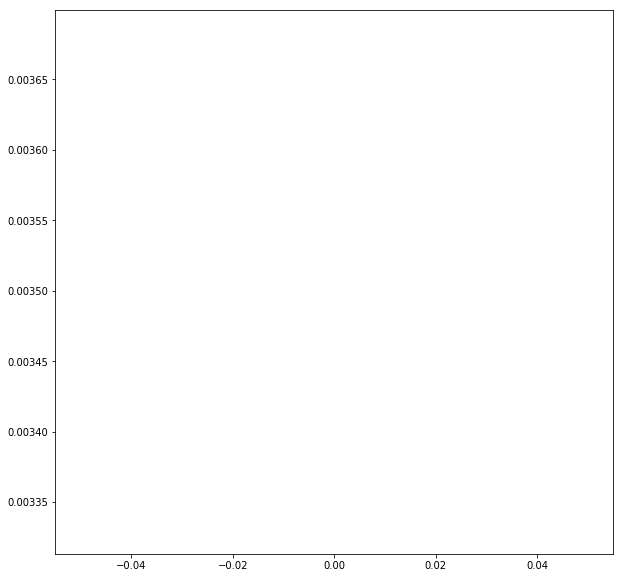

 10%|█         | 50/500 [00:15<02:12,  3.39it/s]

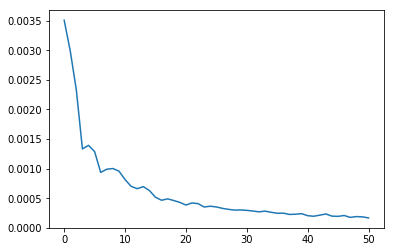

 20%|██        | 100/500 [00:30<01:58,  3.39it/s]

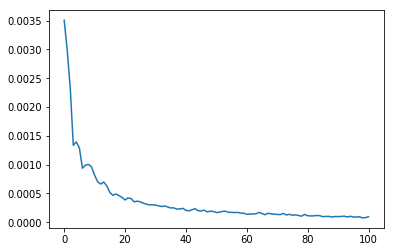

 30%|███       | 150/500 [00:45<01:43,  3.40it/s]

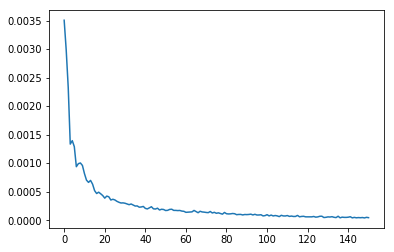

 40%|████      | 200/500 [01:00<01:28,  3.39it/s]

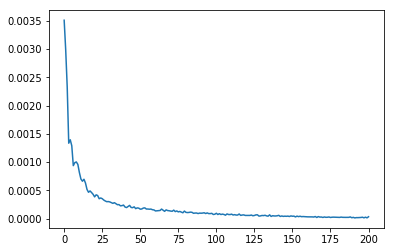

 50%|█████     | 250/500 [01:14<01:13,  3.40it/s]

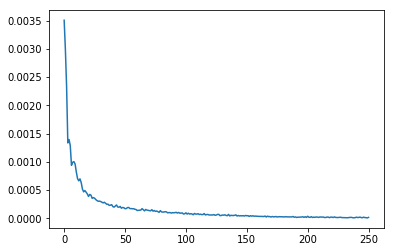

 60%|██████    | 300/500 [01:29<00:58,  3.39it/s]

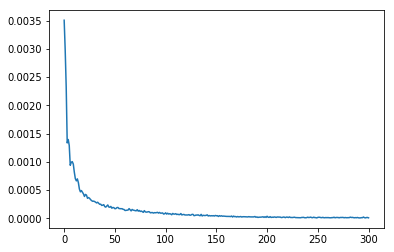

 70%|███████   | 350/500 [01:44<00:44,  3.39it/s]

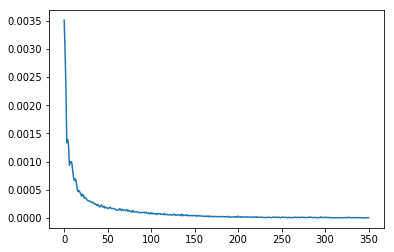

 80%|████████  | 400/500 [01:59<00:29,  3.39it/s]

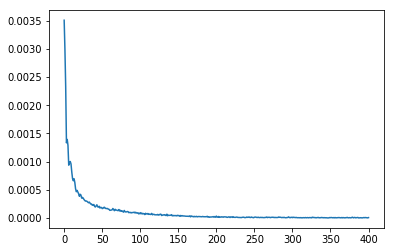

 90%|█████████ | 450/500 [02:14<00:14,  3.40it/s]

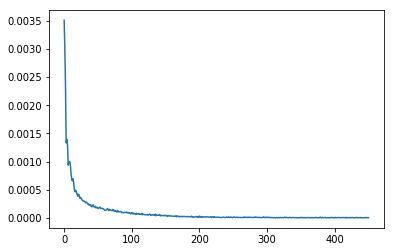

100%|██████████| 500/500 [02:29<00:00,  3.40it/s]


In [6]:
from tqdm import tqdm
losses = []

plt.figure(figsize=(10,10))
dimensions =[50.0,30.0]
norm_factor = 20.0

# Training for loop
for i in tqdm(range(500)):
    imgs, labels = db.generate_batch(num=10, h=dimensions[0], w=dimensions[1], image_size=240)
    imgs_down, labels_down = fr.downsample(imgs, labels)
    
    net.to_gpu(0)

    imgs_gpu = chainer.Variable(cuda.to_gpu(imgs)) #gpu
    
    gt_class, gt_loc = fr.encode_y(imgs_down,norm_factor , labels_down) #cpu
    
    gt_class.to_gpu(0)
    gt_loc.to_gpu(0)

    # Forward pass: SLOW!!!
    pred_class, pred_loc = net(imgs_gpu) #net(imgs) #gpu
    
    
   # Loss calculation
#     class_loss = classification_loss(pred_class, gt_class)

#     class_loss = regression_loss(pred_loc, gt_loc, gt_class)
    
    
    net_loss = loss(pred_class, pred_loc, gt_class, gt_loc, lambd=1.0)
    #print(net_loss.debug_print())
    #net_loss.to_gpu(0)
    
    # Update network
    net.zerograds()
    net_loss.backward()
    optimizer.update()
    
    # Print loss
    #show_image(pred_class.data[0,0,:,:], 'prediction output vgg')
    #
    #show_image(gt_class.data[0,0,:,:], 'class output vgg')
    losses.append(net_loss.data.get())
    
    #print(net_loss.data)
    if i % 50 == 0:
        plt.plot(range(len(losses)), losses)
        plt.show()
    
# Final loss plot


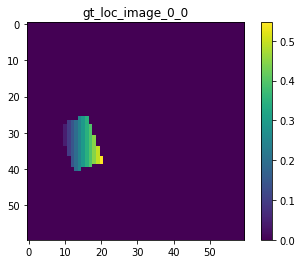

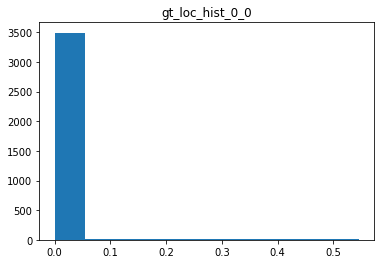

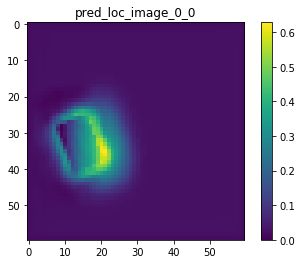

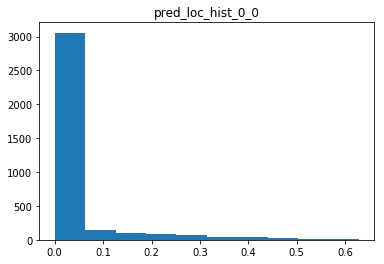

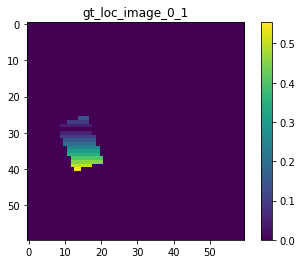

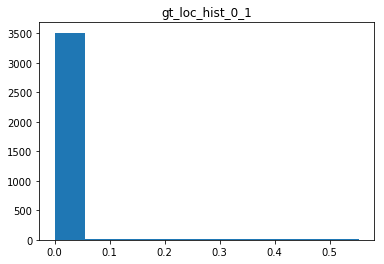

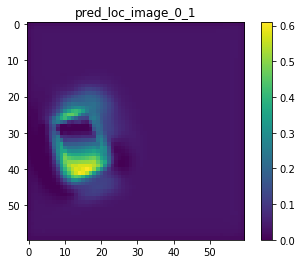

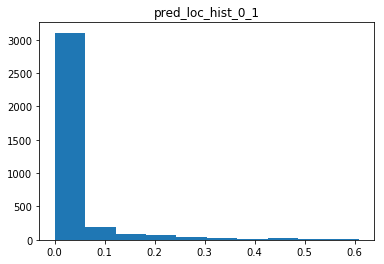

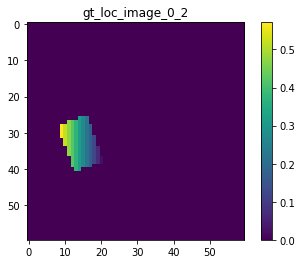

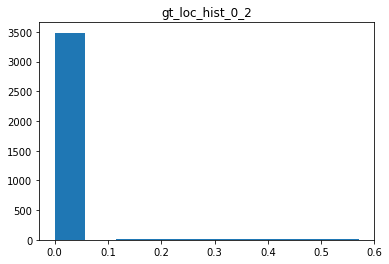

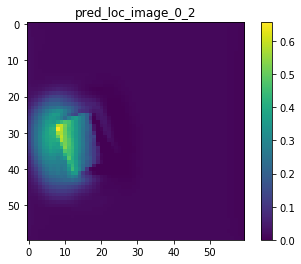

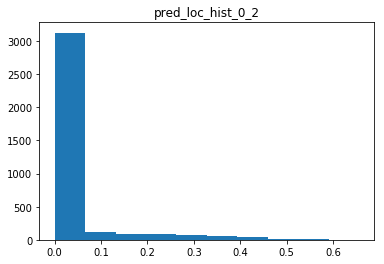

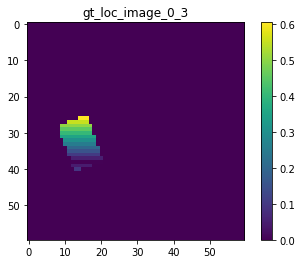

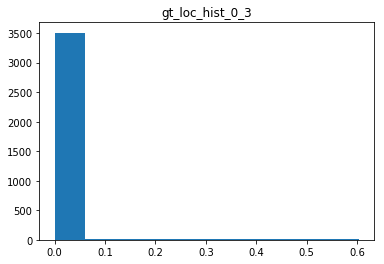

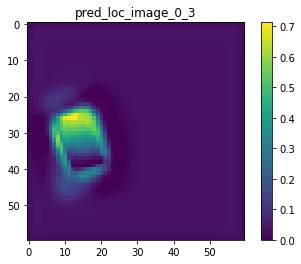

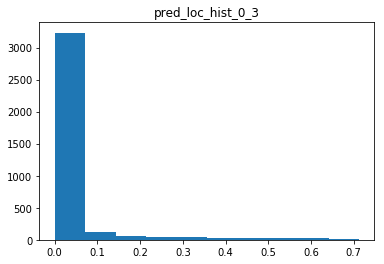

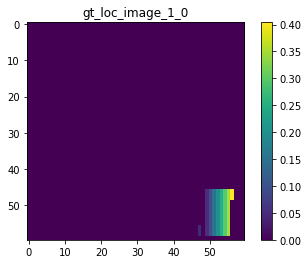

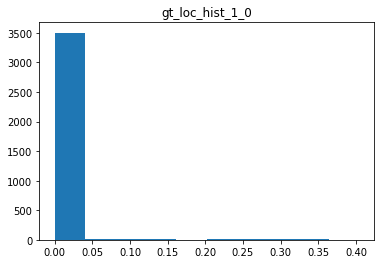

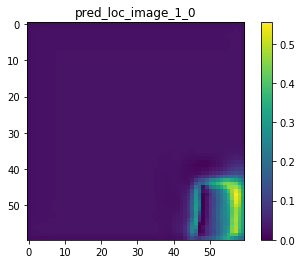

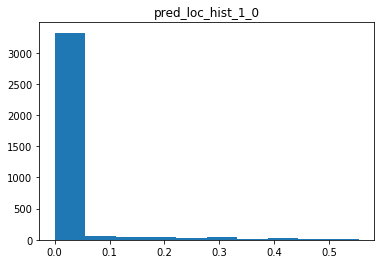

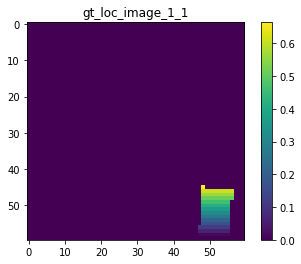

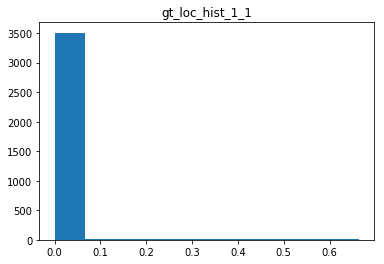

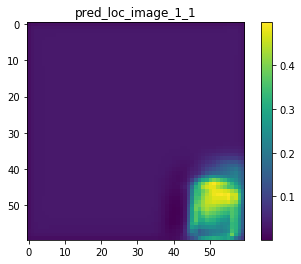

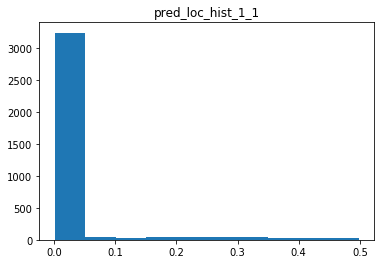

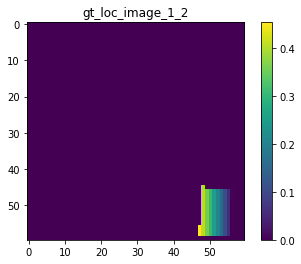

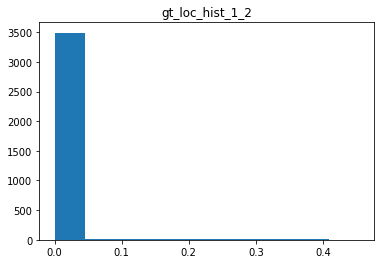

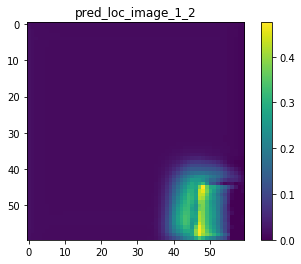

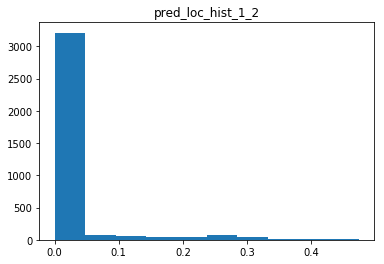

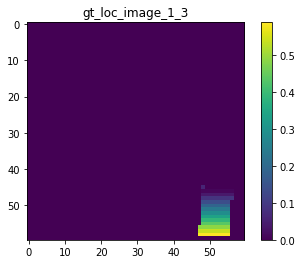

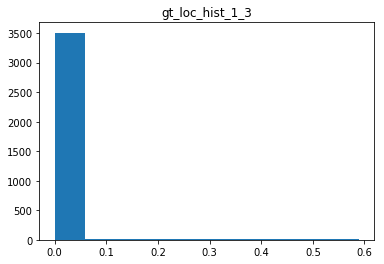

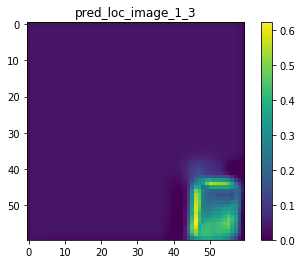

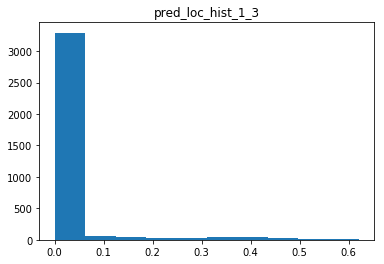

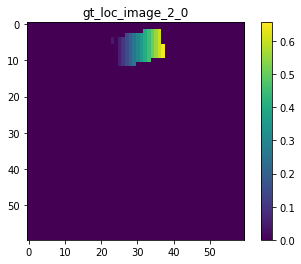

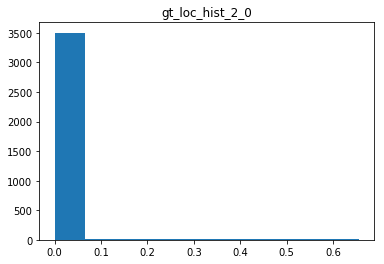

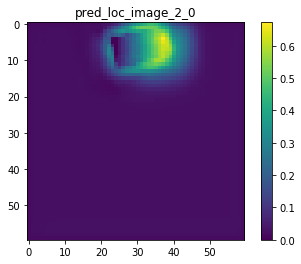

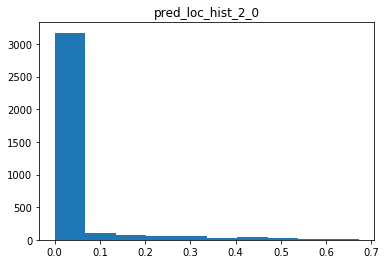

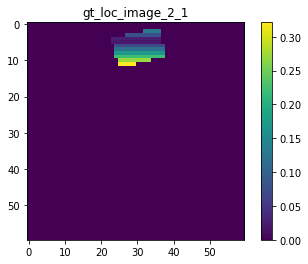

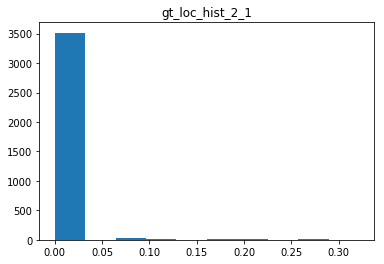

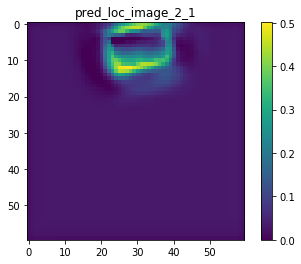

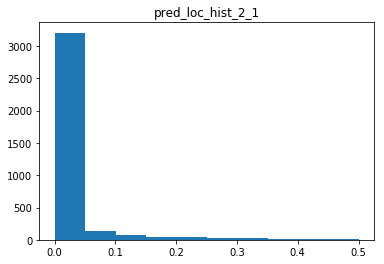

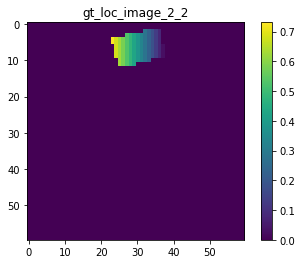

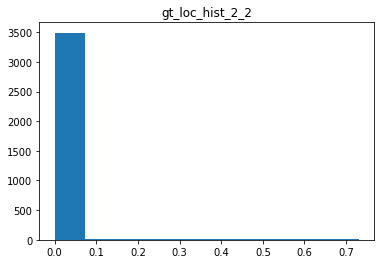

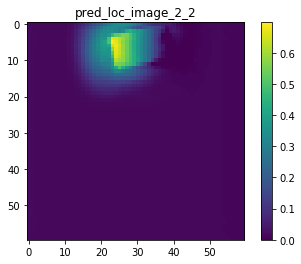

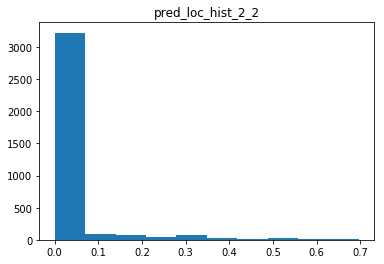

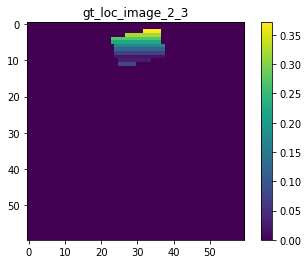

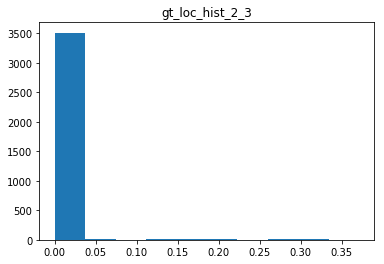

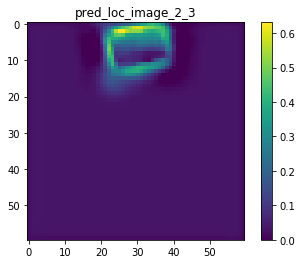

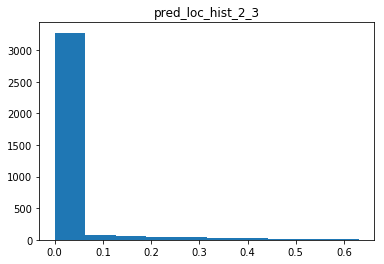

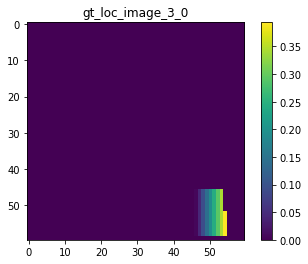

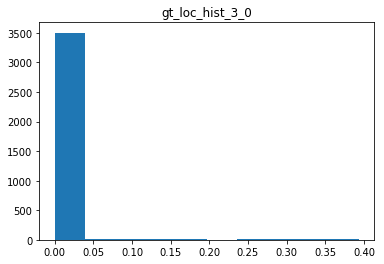

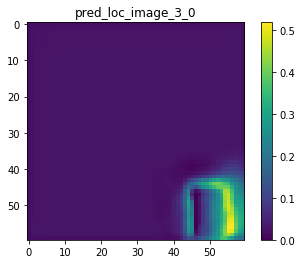

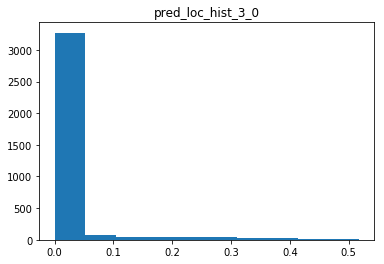

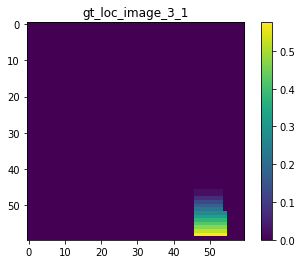

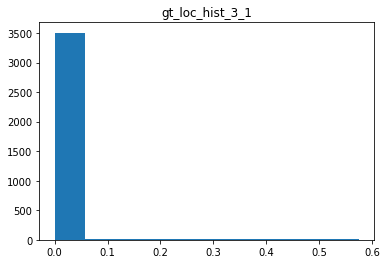

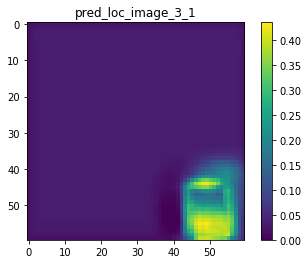

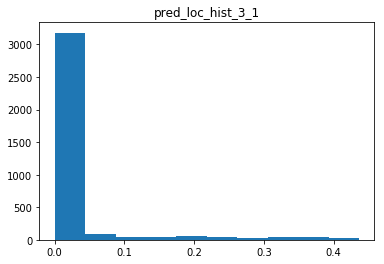

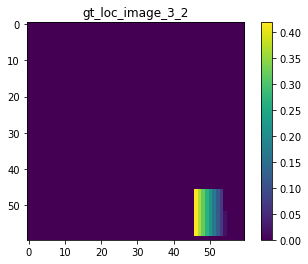

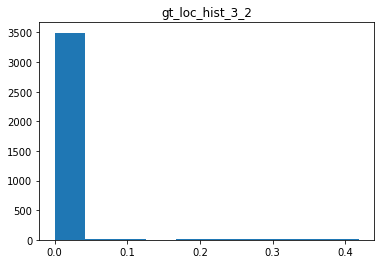

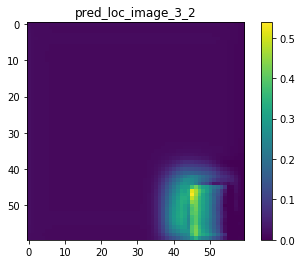

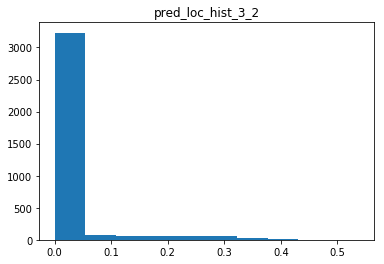

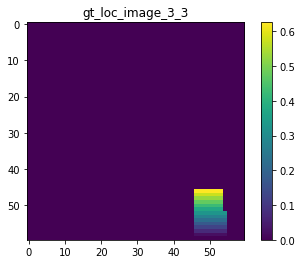

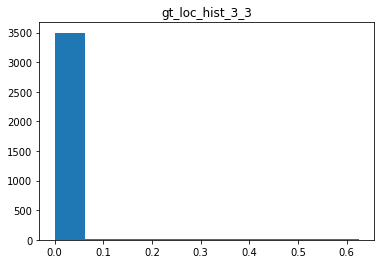

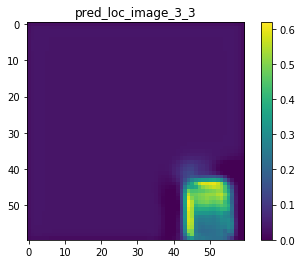

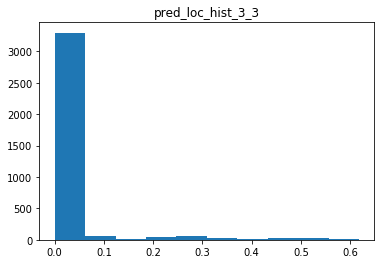

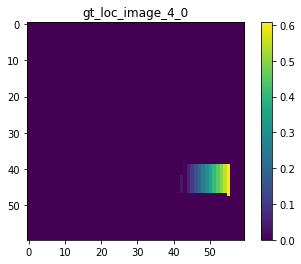

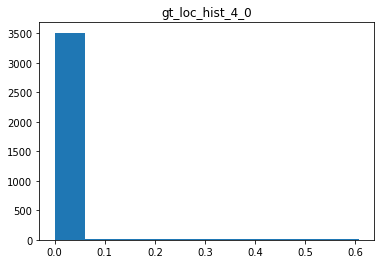

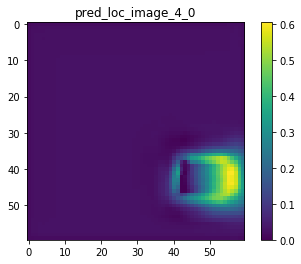

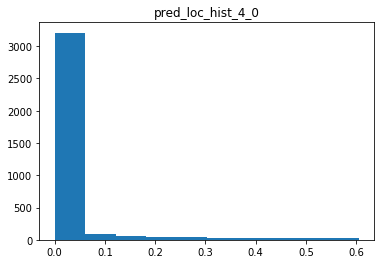

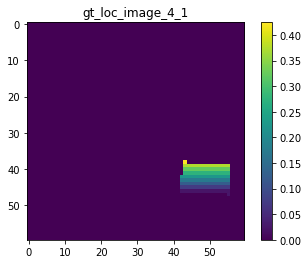

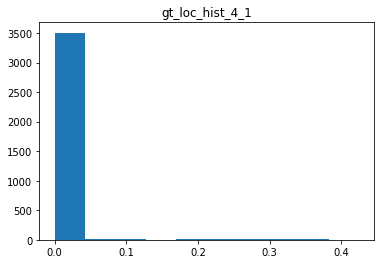

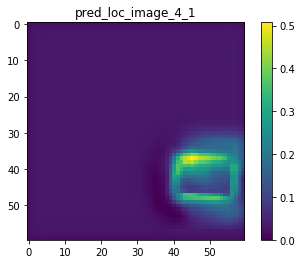

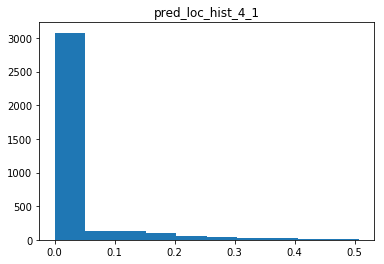

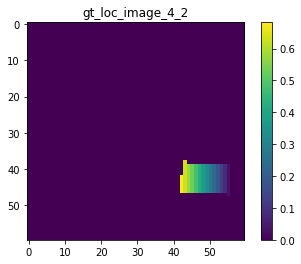

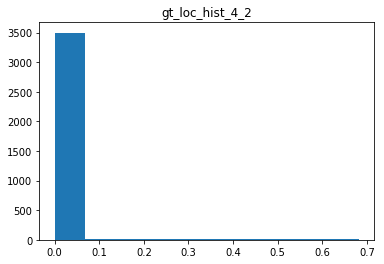

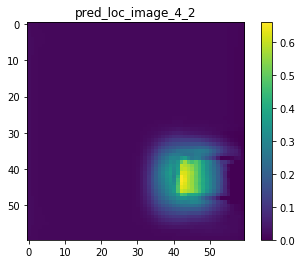

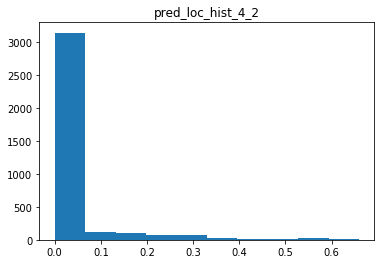

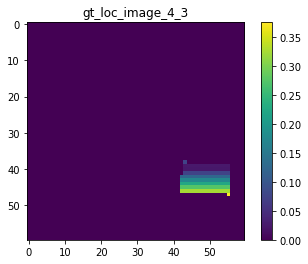

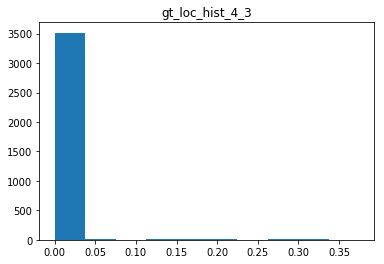

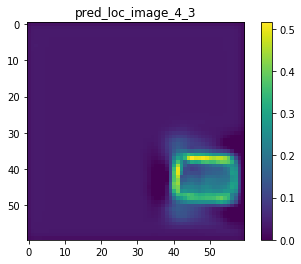

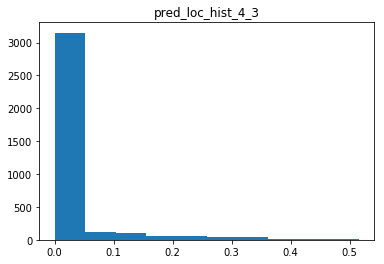

In [7]:
# db = SquaresDataset()
# imgs, labels = db.generate_batch(n=10, h=50, w=50, img_h=240, img_w=240)
# imgs_down, labels_down = downsample(imgs, labels)
gt_loc.to_cpu()
pred_loc.to_cpu()




for i in range(5):
    for c in range(4):
        plt.title("gt_loc_image_%d_%d"%(i, c))
        plt.imshow(gt_loc[i,c,:,:].data,)
        plt.colorbar()
        plt.show()
        
        plt.title("gt_loc_hist_%d_%d"%(i, c))
        plt.hist(gt_loc[i,c,:,:].data.ravel()) 
        plt.show()
        
        plt.title("pred_loc_image_%d_%d"%(i, c))
        plt.imshow(pred_loc[i,c,:,:].data)
        plt.colorbar()
        plt.show()
        
        plt.title("pred_loc_hist_%d_%d"%(i, c))
        plt.hist(pred_loc[i,c,:,:].data.ravel())
        plt.show()
    
        

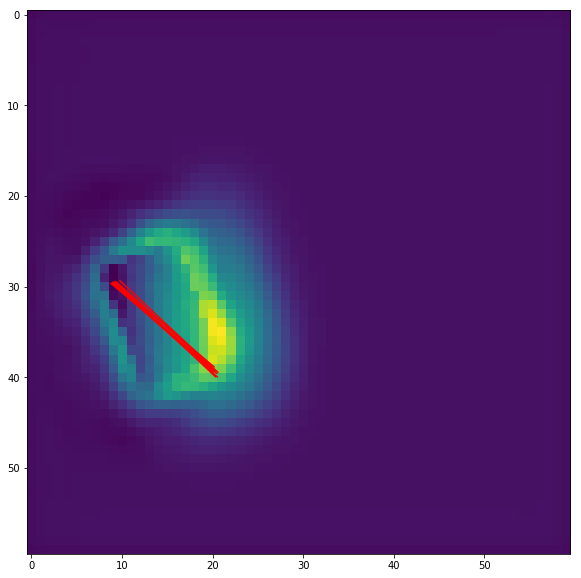

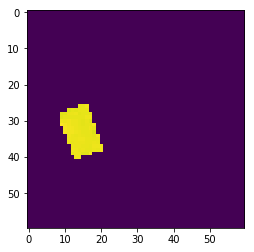

In [123]:
pred_class.to_cpu()
import matplotlib as mt 
pix_loc = [30,30]

# change image number to change the first pred channel
img_num= 0
sorty,sortx,val = np.where(pred_class[img_num,:,:,:].data>0)
pred_class_data = pred_class.data

# find the value of the largest value 
sortedval = np.where(pred_class_data[img_num,:,:,:]>0 )

# array where you have [pred_class value, index_x, index_y]
sortedval_array = np.array((pred_class_data[img_num,:,sortedval[1],sortedval[2]].squeeze(),sortedval[1],sortedval[2]))

# max valued indices on top
max_value_indices = np.flipud(np.argsort(sortedval_array[0,:]))

# pick the first 10 of max values 
subset_indicies = sortedval_array[:,max_value_indices[0:10]]


pty =subset_indicies[1,:]
ptx = subset_indicies[2,:]

pty, ptx = np.where(pred_class[img_num,0,:,:].data>0)
if(pty.shape[0]>100): 
    pty= pty[40:50]
    ptx= ptx[40:50]

# plot pred_loc
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.imshow(pred_loc[img_num,0,:,:].data)

for i in range(pty.shape[0] ):
    pix_x = ptx[i]
    pix_y = pty[i]

    single_box = pred_loc[img_num,:,pix_y,pix_x]

    
    box_coordinates = [pix_x-norm_factor*single_box[0],
                               pix_y-norm_factor*single_box[1], 
                               pix_x+norm_factor*single_box[2], 
                                pix_y+norm_factor*single_box[3]]
    
    # plot lines 
    plt.plot([box_coordinates[0].data,box_coordinates[2].data ],[box_coordinates[1].data,box_coordinates[3].data],'r-' )

# plot pred class   
plt.figure()
plt.imshow( pred_class[img_num,0,:,:].data)
plt.show()


In [78]:
subset_indicies[1,:].shape 

(10,)

In [ ]:
np.unravel_index(pred_class[0,:,:,:].data)